# Step 1. 데이터 다운로드

이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, ~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.   

eminem.txt   
*prince.txt*
radiohead.txt

# Step 2. 데이터 읽어오기

In [1]:
import glob
import os

# txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_file_path = os.getenv('HOME') + '/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # 개행문자(\n)을 기준으로 분리
        raw_corpus.extend(raw)   # 리스트에 같은 배열 요소로 추가. append 객체로 추가

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 [' There must be some kind of way outta here', 'Said the joker to the thief', "There's too much confusion"]


# Step 3. 데이터 정제

앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

### 정규표현식을 이용한 corpus 생성

In [3]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4  알파뱃과 공백 중심으로 추출
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence


print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [31]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue       # 길이가 0인 문장 제외
    if len(sentence) > 57 : continue     # 길이가 57개 초과한 문장 제외
    #if sentence[-1] == ":": continue      # # 문장의 끝이 : 인 문장 제외
    
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
print(len(corpus))
# 정제된 결과를 10개만 확인해보죠
corpus[:10]


155534


['<start> there must be some kind of way outta here <end>',
 '<start> said the joker to the thief <end>',
 '<start> there s too much confusion <end>',
 '<start> i can t get no relief business men , they drink my wine <end>',
 '<start> plowman dig my earth <end>',
 '<start> none were level on the mind <end>',
 '<start> nobody up at his word <end>',
 '<start> hey , hey no reason to get excited <end>',
 '<start> the thief he kindly spoke <end>',
 '<start> there are many here among us <end>']

### tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환

In [114]:
import tensorflow as tf

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,       # 많이 사용된 단어 순으로 12,000개 단어를 관리한다.
        filters=' ',           # 단어 구분자는 공백
        oov_token="<unk>"      # 단어장에 제외된 단어는 <ukn>으로 처리한다.
    )
    tokenizer.fit_on_texts(corpus)  # tokenizer 내부의 단어장 완성
    tensor = tokenizer.texts_to_sequences(corpus)   # 준비한 문장들(corpus)을 정수화(tensor로 변환)
    # padding 제거  , maxlen = 15, padding='post'
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor)  
    return tensor, tokenizer                  # 반환값 : 토큰으로 구성된 문장(tensor), 단어장

tensor, tokenizer = tokenize(corpus)    

In [115]:
#tokenizer.get_config()

In [116]:
tokenizer.get_config().keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [117]:
tokenizer.get_config()['num_words']

12000

In [118]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 15: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in
15 : t


In [119]:
tensor.shape

AttributeError: 'list' object has no attribute 'shape'

In [101]:
print(tensor[:10, :70])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    2   65  273   27   97  540   20   86  758   92
     3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    2  115    6 6097   10    6 2266
     3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    2   65   16   99  184 2736
     3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     2    5   32   15   42   37 5597  795  665    4   45  483   13  948
     3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    2    1 1027   13  651
     3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    2  938  178 1864   18    6  171
     3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0

# Step 4. 평가 데이터셋 분리

In [102]:
##  tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것

In [103]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[1])
print(tgt_input[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    2  115    6 6097   10    6 2266]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    2  115    6 6097   10    6 2266    3]


In [104]:
import numpy as np
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2)

In [105]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124427, 28)
Target Train: (124427, 28)


### tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

In [106]:
BUFFER_SIZE = len(enc_train)          # 메모리 확보
BATCH_SIZE = 256                      # 처리 작업 단위
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))  # 훈련데이터셋과 정답데이터셋
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((256, 28), (256, 28)), types: (tf.int32, tf.int32)>

# Step 5. 인공지능 만들기

## [모델 구조]    

In [107]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [108]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
for enc_sample, dec_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(enc_sample)

<tf.Tensor: shape=(256, 28, 12001), dtype=float32, numpy=
array([[[ 1.7488893e-04, -7.7013810e-06,  1.6426403e-04, ...,
         -1.6843907e-04,  2.0674460e-04, -3.3233879e-04],
        [ 4.2286565e-04, -9.7215961e-06,  4.1585809e-04, ...,
         -4.0515407e-04,  4.6770903e-04, -8.1579626e-04],
        [ 6.9267082e-04, -6.6154216e-06,  7.0394872e-04, ...,
         -6.5419293e-04,  7.0477213e-04, -1.3474638e-03],
        ...,
        [ 3.9513459e-04, -1.2925861e-03, -1.0969159e-04, ...,
         -1.2111806e-03,  8.8797766e-04, -1.3191503e-03],
        [ 4.5175228e-04, -1.0491305e-03, -2.2675387e-04, ...,
         -1.5298753e-03,  1.1912220e-03, -1.0743141e-03],
        [ 5.1230489e-04, -1.0036509e-03, -4.4045909e-04, ...,
         -1.6475758e-03,  1.0870700e-03, -7.4401987e-04]],

       [[ 1.7488893e-04, -7.7013810e-06,  1.6426403e-04, ...,
         -1.6843907e-04,  2.0674460e-04, -3.3233879e-04],
        [ 4.2286565e-04, -9.7215961e-06,  4.1585809e-04, ...,
         -4.0515407e-04, 

In [109]:
model.summary()

Model: "text_generator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_6 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_7 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_3 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


### 학습실행

In [111]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=5)

Epoch 1/5
486/486 [==============================] - 289s 590ms/step - loss: 1.6151
Epoch 2/5
486/486 [==============================] - 288s 593ms/step - loss: 1.4921
Epoch 3/5
486/486 [==============================] - 289s 594ms/step - loss: 1.4420
Epoch 4/5
486/486 [==============================] - 289s 594ms/step - loss: 1.4047
Epoch 5/5
486/486 [==============================] - 288s 593ms/step - loss: 1.3749


### 모델 성과평가

In [112]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [113]:
#generate_text(lyricist, tokenizer, init_sentence="<start> love", max_len=20)
generate_text(model, tokenizer, init_sentence="<start> loving", max_len=20)

'<start> loving whoaaa you <end> '

끝.

1. 패딩조건 : padding = 'pre'
    
2. 학습실행 경과    
첫 번째 에퍽   
Epoch 1/5
486/486 [==============================] - 288s 588ms/step - loss: 2.5711
Epoch 2/5
486/486 [==============================] - 287s 591ms/step - loss: 1.7524
Epoch 3/5
486/486 [==============================] - 288s 593ms/step - loss: 1.6767
Epoch 4/5
486/486 [==============================] - 289s 594ms/step - loss: 1.6454
Epoch 5/5
486/486 [==============================] - 289s 595ms/step - loss: 1.6025
<tensorflow.python.keras.callbacks.History at 0x7fab3462c710>  

두 번째 에퍽
Epoch 1/5
486/486 [==============================] - 289s 590ms/step - loss: 1.6151
Epoch 2/5
486/486 [==============================] - 288s 593ms/step - loss: 1.4921
Epoch 3/5
486/486 [==============================] - 289s 594ms/step - loss: 1.4420
Epoch 4/5
486/486 [==============================] - 289s 594ms/step - loss: 1.4047
Epoch 5/5
486/486 [==============================] - 288s 593ms/step - loss: 1.3749
<tensorflow.python.keras.callbacks.History at 0x7fabc9a2a090>

3. 문장 만들기  
'<start> loving whoaaa you <end> '

1. 패딩조건 : padding = 'pre', maxlen=15
    
2. 학습실행 경과    
Epoch 1/5
486/486 [==============================] - 152s 307ms/step - loss: 4.2835
Epoch 2/5
486/486 [==============================] - 149s 307ms/step - loss: 3.2429
Epoch 3/5
486/486 [==============================] - 149s 306ms/step - loss: 3.1159
Epoch 4/5
486/486 [==============================] - 149s 307ms/step - loss: 3.0098
Epoch 5/5
486/486 [==============================] - 149s 306ms/step - loss: 2.9106
<tensorflow.python.keras.callbacks.History at 0x7fabca5d7410>

두 번째 에퍽   
Epoch 1/5
486/486 [==============================] - 150s 303ms/step - loss: 2.8587
Epoch 2/5
486/486 [==============================] - 149s 307ms/step - loss: 2.7239
Epoch 3/5
486/486 [==============================] - 149s 307ms/step - loss: 2.6272
Epoch 4/5
486/486 [==============================] - 149s 306ms/step - loss: 2.5213
Epoch 5/5
486/486 [==============================] - 149s 305ms/step - loss: 2.4236
<tensorflow.python.keras.callbacks.History at 0x7fabcdccc910>

세 번째 에퍽   
Epoch 1/5
486/486 [==============================] - 149s 302ms/step - loss: 2.3696
Epoch 2/5
486/486 [==============================] - 150s 308ms/step - loss: 2.2670
Epoch 3/5
486/486 [==============================] - 150s 308ms/step - loss: 2.1730
Epoch 4/5
486/486 [==============================] - 148s 304ms/step - loss: 2.0932
Epoch 5/5
486/486 [==============================] - 150s 307ms/step - loss: 2.0091
<tensorflow.python.keras.callbacks.History at 0x7fabc01d3550>

3. 문장만들기   
'<start> loving you , i m a voodoo chile , i m a flirt <end> '

1. 패딩 조건 : padding='post' , maxlen = 15(15 컬럼만 추출)    
    
2. 학습실행 경과    
Epoch 1/5  
486/486 [==============================] - 150s 302ms/step - loss: 4.0748  
Epoch 2/5  
486/486 [==============================] - 150s 307ms/step - loss: 3.0449  
Epoch 3/5  
486/486 [==============================] - 148s 305ms/step - loss: 2.8595  
Epoch 4/5  
486/486 [==============================] - 147s 303ms/step - loss: 2.7254  
Epoch 5/5  
486/486 [==============================] - 149s 306ms/step - loss: 2.6132  
<tensorflow.python.keras.callbacks.History at 0x7fabce2a5e10>    
    
Epoch 1/5
486/486 [==============================] - 150s 304ms/step - loss: 2.5584
Epoch 2/5
486/486 [==============================] - 149s 307ms/step - loss: 2.4237
Epoch 3/5
486/486 [==============================] - 149s 306ms/step - loss: 2.3060
Epoch 4/5
486/486 [==============================] - 149s 307ms/step - loss: 2.2037
Epoch 5/5
486/486 [==============================] - 149s 306ms/step - loss: 2.1013
<tensorflow.python.keras.callbacks.History at 0x7fac4f433f10>   

- 문장만들기 결과
'<start> loving you , baby <end> '

- 패딩 조건 : post    
     
- 학습경과
첫번째 5에폭 결과    
Epoch 1/5
486/486 [==============================] - 292s 596ms/step - loss: 2.2993
Epoch 2/5
486/486 [==============================] - 291s 597ms/step - loss: 1.5372
Epoch 3/5
486/486 [==============================] - 290s 597ms/step - loss: 1.4425
Epoch 4/5
486/486 [==============================] - 290s 596ms/step - loss: 1.3783
Epoch 5/5
486/486 [==============================] - 289s 594ms/step - loss: 1.3165
<tensorflow.python.keras.callbacks.History at 0x7fabd3866090>   
    
두 번째 5에폭 결과  
Epoch 1/5
486/486 [==============================] - 288s 587ms/step - loss: 1.2850
Epoch 2/5
486/486 [==============================] - 287s 590ms/step - loss: 1.2162
Epoch 3/5
486/486 [==============================] - 287s 590ms/step - loss: 1.1565
Epoch 4/5
486/486 [==============================] - 289s 593ms/step - loss: 1.0998
Epoch 5/5
486/486 [==============================] - 289s 593ms/step - loss: 1.0496
<tensorflow.python.keras.callbacks.History at 0x7fabd30d11d0>   
   
- 문장만들기 결과     
'<start> loving you , i m not afraid to do <end> '

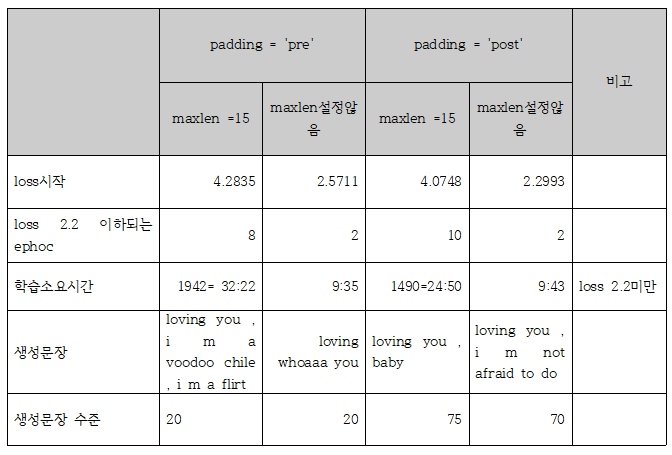

- 패딩을 문장 앞에 하는 것 보다 문장 뒤에 하는 것이 효과적이다.  
- 토큰을 제한 하는 것보다 제한하지 않는 것이 학습시간이 절약되고 문장의 자연스러움도 제한한 것과 비슷한 수준으로 작문한다.   
- 패딩을 하지않는 것을 시도하려 하였으나 토큰 객체 생성이 되지 않는다는 것을 확인함.